In [1]:
import numpy as np
from tqdm import tqdm_notebook
from env import EnvSpec, Env, EnvWithModel
from policy import Policy
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
from mpl_toolkits import mplot3d

In [2]:
class RandomPolicy(Policy):
    def __init__(self, nA, p=None):
        self.p = p if p is not None else np.array([1/nA]*nA)

    def action_prob(self, state, action=None):
        return self.p[action]

    def action(self, state):
        return np.random.choice(len(self.p), p=self.p)        

## GridWorld

In [15]:
class GridWorld(EnvWithModel):

    def __init__(self, w = [0.25,0.25,0.25,0.25]):
    
    # 150 States. [0,1,2,3,4,5] Initialization. [144,145,146,147,148,148] terminal
    # 3 actions 0 right, 1 up, 2 down
    
        env_spec = EnvSpec(150, 3, 1.)
        super().__init__(env_spec)
        self.trans_mat, self.r1, self.r2, self.r3, self.r4 = self._build_trans_mat()
        self.terminal_state = [144, 145, 146, 147, 148, 149]
        self.nLitter = 15
        self.nObstacles = 15
        self.w = w
        self.state = 0
        self.action = 0
        
    def _build_trans_mat(self):
        
        # TODO: Add Modular Rewards Later
        
        # t(s,a,s')
        trans_mat = np.zeros((150,3,150), dtype=int)
        
        # Module 1 -- Goal
        r_1 = np.zeros((150,3,150), dtype=int) - 10.
        # Module 2 -- Sidewalk
        r_2 = np.zeros((150,3,150), dtype=int) - 10.
        # Module 3 -- Obstacles
        r_3 = np.zeros((8,3,8))
        # Module 4 -- Litter
        r_4 = np.zeros((8,3,8))
        
        for s in range(150):
           
            # Transition Dynamics 
            if s < 144:
                trans_mat[s][0][s+6] = 1.   # Moving to Right
            if s == 0 or s % 6 == 0:
                trans_mat[s][1][s] = 1.     # Banging into top wall
            else:
                trans_mat[s][1][s-1] = 1.   # Moving up
            if (s+1) % 6 == 0:
                trans_mat[s][2][s] = 1.     # Banging into Bottom wall
            else:
                trans_mat[s][2][s+1] = 1.   # Moving Down
            
            # First Module - Initialized with all -1
            if s == 0 or s%6 == 0: 
                r_1[s][1][s] = -10.         # Banging into top wall -10
            if (s+1)%6 == 0:
                r_1[s][2][s] = -10.          # Banging into bottom wall -10
            if s >=138 and s <= 143:
                r_1[s][0][s+6] = 10.        # Reaching goal state -10
                
            # Sidewalk Module - Initilaized with zeros
            if (s==2 or (s-2)%6 == 0) and s<144:                # Top row of sidewalk
                r_2[s][0][s+6] = 1.         # Moving Right on the side walk +1 
                r_2[s][1][s-1] = 0.        # Moving out of the side walk    
                r_2[s][2][s+1] = 0.
            if (s==3 or (s-3)%6 == 0) and s<144:                # Bottom row of sidewalk 
                r_2[s][0][s+6] = 1.       # Moving Right on the side walk +1
                r_2[s][2][s+1] = 0.        # Moving out of the side walk  
                r_2[s][1][s-1] = 0.
            if (s==1 or (s-1)%6 == 0) and s<144:                # Positive reward for moving into the sidewalk    
                r_2[s][2][s+1] = 0.
            if (s==4 or (s-4)%6 == 0) and s<144:
                r_2[s][1][s-1] = 0.
                
        for a in range(3):
        # Once in terminal - Be in terminal
            for s in range(144,150):
                trans_mat[s][a][s] = 1.

        # Obstacle and Litter Rewards
        for s in range(8):
            binState = np.binary_repr(s,width=3)
            # Right
            if binState[0] == '1':
                r_3[s][0][:] = -10.        # Moving right into obstacle
                r_4[s][0][:] = 5.          # Moving right into Litter
            else:
                r_3[s][0][:] = 3.         # Moving right no obstacle
                r_4[s][0][:] = 0.          # Moving right no litter
            # up
            if binState[1] == '1':
                r_3[s][1][:] = -10.        # Moving up into obstacle
                r_4[s][1][:] = 5.          # Moving up into Litter
            else:
                r_3[s][1][:] = -2.        # Moving up no obstacle
                r_4[s][1][:] = 0.          # Moving up no litter
            #down
            if binState[2] == '1':
                r_3[s][2][:] = -10.        # Moving down into obstacle
                r_4[s][2][:] = 5.          # Moving down into Litter
            else:
                r_3[s][2][:] = -2.        # Moving down no obstacle
                r_4[s][2][:] = 0.          # Moving down no litter
        
        return trans_mat, r_1, r_2, r_3, r_4
        
    @property
    def TD(self) -> np.array:
        return self.trans_mat
        
    @property
    def R(self) -> np.array:
        return self.ret_mat
        
    def reset(self) -> int:
        
        AllStates = np.arange(144)
        
        self.Obstacles = np.random.choice(AllStates, self.nObstacles)
        RemainingStates = np.delete(AllStates, self.Obstacles)
        self.Litter = np.random.choice(RemainingStates, self.nLitter)
        EmptyStates = np.delete(RemainingStates, self.Litter)
        
        # Random initialization of the state
        self.state = np.random.choice(EmptyStates[:12])
        return self.state
        
    # gives binary representation of surrounding states.
    def getObstacles(self):
        if (self.state+6) in self.Obstacles:
            Obs = '1'
        else:
            Obs = '0'
        if ((self.state-1)!=0 or (self.state-1)%6!=0) and (self.state-1) in self.Obstacles:
            Obs += '1'
        else:
            Obs += '0'
        if (self.state+1)%6!=0 and (self.state+1) in self.Obstacles:
            Obs += '1'
        else:
            Obs += '0'
        return Obs               
            
    def getLitter(self):
        if (self.state+6) in self.Litter:
            Lit = '1'
        else:
            Lit = '0'
        if ((self.state-1)!=0 or (self.state-1)%6!=0) and (self.state-1) in self.Litter:
            Lit += '1'
        else:
            Lit += '0'
        if (self.state+1)%6!=0 and (self.state+1) in self.Litter:
            Lit += '1'
        else:
            Lit += '0'
        return Lit
            
    def step(self, action):   
        assert action in range(self.spec.nA), "Invalid action"
        assert self.state not in self.terminal_state, "Episode has ended"
            
        prevState = self.state
        decObs_t = int(self.getObstacles(),2)
        decLit_t = int(self.getLitter(),2)
        self.state = np.random.choice(self.spec.nS, p=self.trans_mat[self.state, action])
        decObs_t1 = int(self.getObstacles(),2)
        decLit_t1 = int(self.getLitter(),2)   
        
        r1 = self.r1[prevState, action, self.state]
        r2 = self.r2[prevState, action, self.state]
        r3 = self.r3[decObs_t, action, decObs_t1]
        r4 = self.r4[decLit_t, action, decLit_t1]
        
        if self.state in self.terminal_state:
            return self.state, r1, r2, r3, r4, True
        else:
            return self.state, r1, r2, r3, r4, False 
        
    def visualize(self, episode=0):
        
        Grid = np.zeros((6, 25))
        
        for i in range(6):
            # Termination = 1
            Grid[i][24] = 1
            
            # Sidewalk = 2 
            if i == 2 or i == 3:
                Grid[i][:24] = 2
        
        # Obstacles  = 3
        for i in self.Obstacles:
            Grid[i%6][int(i/6)] = 3
        
        # Litter = 4
        for i in self.Litter:
            Grid[i%6][int(i/6)] = 4
            
        cmap = colors.ListedColormap(['white', 'blue' , 'green', 'red', 'orange'])
        
        
        plt.figure(figsize=(12,15))
        plt.imshow(Grid, cmap = cmap)
        
        if episode != 0:
            for i in episode:
                plt.scatter(int(i/6),i%6, marker='*')

        plt.title("Grid World")
        plt.show()

(2, -10.0, 0.0, -2.0, 0.0, False)


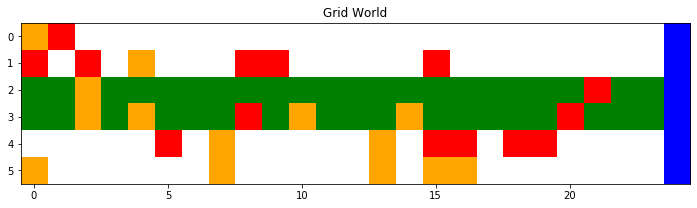

In [16]:
# Environment Testing
env = GridWorld()
TD = env.trans_mat
env.spec.nS
env.reset()
env.state = 3
print(env.step(1))
env.visualize()

## Epsilon Greedy Policy

In [17]:
class EGPolicy(Policy):
    def __init__(self, Q, e=0.05):
        self.Q = Q
        self.e = e
        
    def action_prob(self, state, action):
        values = np.exp(self.Q[state][:])
        summation = np.sum(values)
        Prob = values[action]/summation
        return Prob
    
    def action(self, state):
        if np.random.rand() < self.e:
            action = np.random.choice([0,1,2])
        else:
            action = np.argmax(self.Q[state][:])
        return action    

## Modular Q Learning 

In [18]:
# Q Learning on one Module
def QLearning(
    env,
    pi:Policy,
    n:int,
    alpha:float
    ):
    
    nS = env.spec.nS
    nA = env.spec.nA
    gamma = env.spec.gamma
    
    # Q values
    QGoal = np.zeros((nS, nA))
    QSw = np.zeros((nS, nA))
    QObs = np.zeros((2**nA, nA))
    QLit = np.zeros((2**nA, nA))
    
    # State Values
    VGoal = np.zeros(nS)
    VSw = np.zeros(nS)
    VObs = np.zeros(2**nA)
    VLit = np.zeros(2**nA)
    
    Trajectories = []
    Returns = []
    
    for episode in tqdm_notebook(range(n)):
        
        isTerminated = False
        state = env.reset()
        traj = []
        reward = [0,0,0,0]
        actions = [0,1,2]
        
        while not isTerminated:
            
            # Getting policies (e-greedy)
            pGoal = pi(QGoal)
            pSw =  pi(QSw)
            pObs = pi(QObs)
            pLit = pi(QLit)
            
            # Getting actions for each module
            sObs = int(env.getObstacles(), 2)
            sLit = int(env.getLitter(), 2)
            
            a = [0,0,0,0]
            a[0] = pGoal.action(state)
            a[1] = pSw.action(state)
            a[2] = pObs.action(sObs)
            a[3] = pLit.action(sLit)
            
            m1 = np.max(QGoal)
            m2 = np.max(QSw[state-6:])
            m3 = np.max(QObs)
            m4 = np.max(QLit)
            
            mean1 = np.mean(QGoal)
            mean2 = np.mean(QGoal)
            mean3 = np.mean(QGoal)
            mean4 = np.mean(QGoal)
            
            # Choosing action with best immediate reward
            index = np.argmax([env.w[0]*(QGoal[state][a[0]]-mean1)/m1, env.w[1]*(QSw[state][a[1]]-mean2)/m2 , env.w[2]*(QObs[sObs][a[2]]-mean3)/m3 , env.w[3]*(QLit[sLit][a[3]]-mean4)/m4])
#             index = np.argmax(env.w[0]*(QGoal[state][:]) +  env.w[1]*(QSw[state][:]) + env.w[2]*(QObs[sObs][:]) + env.w[3]*(QLit[sLit][:]))
            action = a[index]
            
            # Taking a step and getting rewards
            s_hat, R1, R2, R3, R4, isTerminated = env.step(action)
            
            sObs_hat = int(env.getObstacles(), 2)
            sLit_hat = int(env.getLitter(), 2)
            
            # Updating rewards
            reward[0] += R1
            reward[1] += R2
            reward[2] += R3
            reward[3] += R4
            
            # Updaing Q values
            QGoal[state][action] = QGoal[state][action] + alpha*(R1 + 0.9*gamma*np.max(QGoal[s_hat][:]) - QGoal[state][action])
            QSw[state][action] = QSw[state][action] + alpha*(R2 + 0.9*gamma*np.max(QSw[s_hat][:]) - QSw[state][action])
            QObs[sObs][action] =  QObs[sObs][action] + alpha*(R3 + 0.0*np.max(QObs[sObs_hat][:]) -  QObs[sObs][action])
            QLit[sLit][action] =  QLit[sLit][action] + alpha*(R4 + 0.0*np.max(QLit[sLit_hat][:]) -  QLit[sLit][action])
            
            # Update State Values
            VGoal[state] = np.sum(np.multiply(pGoal.action_prob(state, np.arange(nA)), QGoal[state][:])) 
            VSw[state] = np.sum(np.multiply(pSw.action_prob(state, np.arange(nA)), QSw[state][:]))
            VObs[sObs] = np.sum(np.multiply(pObs.action_prob(sObs, np.arange(nA)), QObs[sObs][:]))
            VLit[sLit] = np.sum(np.multiply(pLit.action_prob(sLit, np.arange(nA)), QLit[sLit][:]))
            
            # Storing Trajectory
            state = s_hat
            traj.append(state)
            
        traj.append(s_hat)
        Trajectories.append(traj)
        Returns.append(reward)
        if episode >= 0.999*n:
            env.visualize(traj)
    
    return [QGoal, QSw, QObs, QLit], [VGoal, VSw, VObs, VLit], Trajectories, Returns

## Trajectories of last 10 episodes

Plotting the last 10 tranining episodes


/home/bharath/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/bharath/.local/lib/python3.6/site-packages/ipykernel_launcher.py:115: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
/home/bharath/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in double_scalars
/home/bharath/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in double_scalars


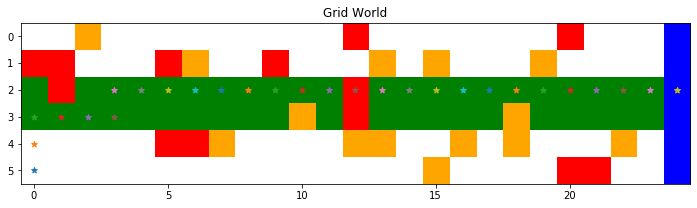

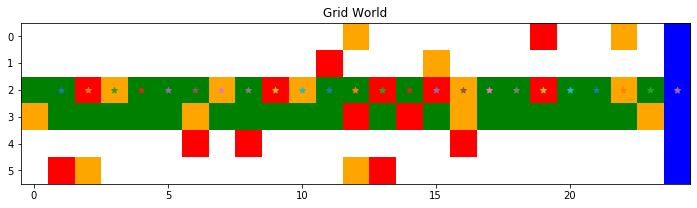

In [19]:
# Simple Q-Learning Test
Environment = GridWorld([1.,0,0,0])
print("Plotting the last 10 tranining episodes")
QValues, SVals, Episodes, Returns = QLearning(Environment, EGPolicy, 2000, 0.1)

## State values of all modules

Text(0.5, 0, 'd')

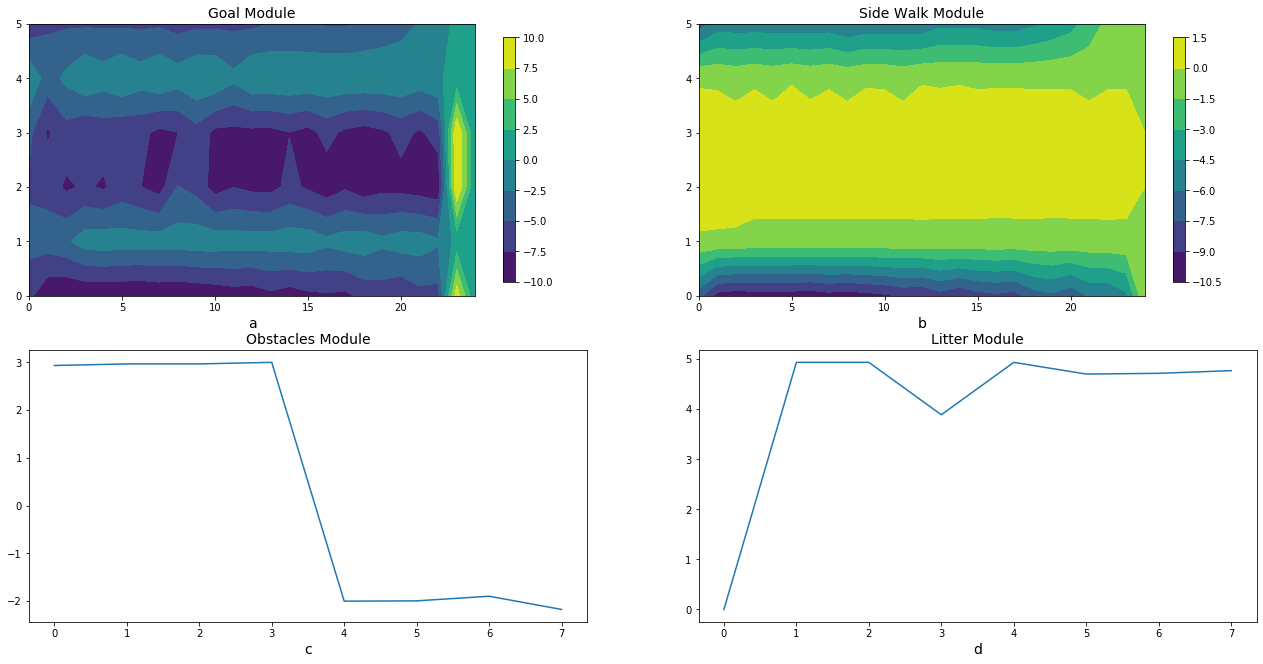

In [11]:
# PLotting value function

y = np.arange(6)
x = np.arange(25)
X,Y = np.meshgrid(x,y)

Z = SVals[0][X*6 + Y]
fig,ax=plt.subplots(2,2, figsize=(22, 11))

cp = ax[0,0].contourf(X, Y, Z)
fig.colorbar(cp, ax=ax[0,0], shrink=0.9)
ax[0,0].set_title('Goal Module', fontsize=14)
ax[0,0].set_xlabel('a', fontsize=14)

Z = SVals[1][X*6 + Y]
cp = ax[0,1].contourf(X, Y, Z)
ax[0,1].set_title('Side Walk Module', fontsize=14)
fig.colorbar(cp, ax=ax[0,1], shrink=0.9)
ax[0,1].set_xlabel('b', fontsize=14)

ax[1,0].plot(range(8),SVals[2])
ax[1,0].set_title('Obstacles Module', fontsize=14)
ax[1,0].set_xlabel('c' ,fontsize=14)

ax[1,1].plot(range(8),SVals[3])
ax[1,1].set_title('Litter Module', fontsize=14)
ax[1,1].set_xlabel('d', fontsize=14)


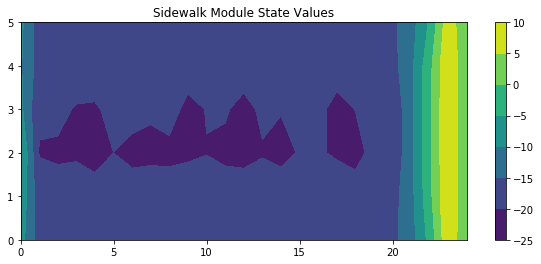

In [20]:
# # Module Sidewalk
y = np.arange(6)
x = np.arange(25)
X,Y = np.meshgrid(x,y)

Z = SVals[0][X*6 + Y]

fig,ax=plt.subplots(1,1, figsize=(10,4))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Sidewalk Module State Values')
plt.show()

Text(0.5, 1.0, 'Obstacles Module State Values')

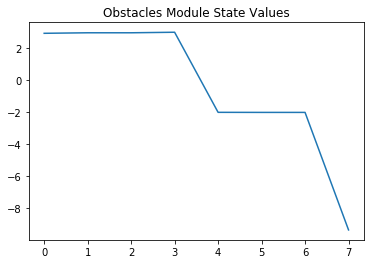

In [371]:
plt.plot(range(8),SVals[2])
plt.title('Obstacles Module State Values')

Text(0.5, 1.0, 'Litter Module State Values')

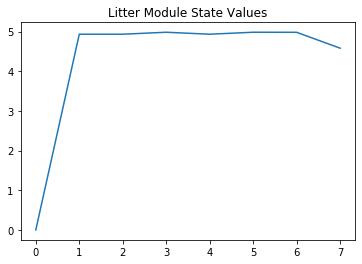

In [372]:
# Module - Litter
plt.plot(range(8),SVals[3])
plt.title('Litter Module State Values')